# Contents

<div style="font-size: 16px;">
    A model to detect spine discs in axial images is unnecessary, because only one disc is visible in one axial image. Thus, we simply crop the images in training and validation set with fixed coordinates and save them for future training and validation.
</div>

- xx
- xx
- xx

In [1]:
!pip install pydicom -q
!pip uninstall torch torchvision -y
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

# Configs

In [2]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [3]:
CONDITION = 'LeftSubarticularStenosis'

## Load libraries

In [4]:
import os
import time
import random
from datetime import datetime
import numpy as np
import collections

from matplotlib import animation, rc
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt

import tqdm
import sys

## Directories

In [5]:
# Directories
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '02_train_disc_detection', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## Functions

In [6]:
with open(os.path.join(SRC_DIR, 'data.py')) as file:
    exec(file.read())

## Metadata

In [7]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

## Hyperparameters

In [8]:
CONFIG = dict(
    box_w = 80, # width of the boxes
    box_h = 80, # height of the boxes
)

# Crop Image with Fixed Coords

In [25]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

def get_center_bbox(w, h, w_orig, h_orig):

    w_c = w_orig / 2
    h_c = h_orig / 2

    x0, y0, x1, y1 = w_c - w / 2, h_c - h / 2, w_c + w / 2, h_c + h / 2
    
    return x0, y0, x1, y1

def crop_bbox(image, w, h):
    
    w_orig, h_orig = image.shape[-1], image.shape[-2]
    # print(w_orig, h_orig)
    
    x0, y0, x1, y1 = get_center_bbox(w, h, w_orig, h_orig)

    cropped_img = torchvision.transforms.functional.crop(
        image,
        top=round(int(y0)),
        left=round(int(x0)),
        height=round(int(y1 - y0)),
        width=round(int(x1 - x0))
    )
    return cropped_img


def plot_crop(image, bbox):

    cropped_img = crop_bbox(image, CONFIG['box_w'], CONFIG['box_h'])
    cropped_img = cropped_img[0, :]
    # print(cropped_img.shape)
    plt.imshow(cropped_img, cmap="bone")

def save_crop(image, bbox, row):
    series_id = row['series_id']
    study_id = row['study_id']
    instance_number = row['instance_number']
    label = LABELS_DICT[row['level_code']]

    dirname = f'{CROP_DIR}/{study_id}/{series_id}/{label}'
    os.makedirs(dirname, exist_ok=True)
    filepath = os.path.join(dirname, f'{instance_number}.pt')

    cropped_img = crop_bbox(image, CONFIG['box_w'], CONFIG['box_h'])
    torch.save(cropped_img, filepath)

    return

In [13]:
def crop_and_save_boxes(df, limit = None):
    for i, row in tqdm.tqdm(df.iterrows()):
        path = row['image_path']
        image = load_image_from_path(path)
        bbox = crop_bbox(image, CONFIG['box_w'], CONFIG['box_h'])
        save_crop(image, bbox, row)

In [15]:
crop_and_save_boxes(df = train_df, limit = None)

6939it [07:36, 15.20it/s]


In [16]:
crop_and_save_boxes(df = val_df, limit = None)

1223it [01:56, 10.46it/s]


## Check out a few crops with different conditions

In [17]:
def load_crop(row, plot=True, title=None, output=True):
    file = f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"
    crop = torch.load(file).squeeze(0)
    if plot:
        plt.imshow(crop, cmap="bone")
        if title: plt.title(title)
        plt.show()
    if output:
        return crop

In [18]:
x = load_crop(train_df.iloc[0], plot=False, output=True)
trans = T.ToDtype(torch.float, scale=True)
y = trans(x)

### L1/L2 crops

In [19]:
train_df[train_df.level_code == 1].groupby('severity').head(n=1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,level_code,severity_code
0,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,3,179.126448,161.235521,Axial T2,/home/jupyter/data/train_images/4003253/244819...,1,0
70,41477684,Left Subarticular Stenosis,L1/L2,Moderate,3749739759,4,281.848761,239.580175,Axial T2,/home/jupyter/data/train_images/41477684/37497...,1,1
133,75336136,Left Subarticular Stenosis,L1/L2,Severe,3843947211,7,185.349294,190.643642,Axial T2,/home/jupyter/data/train_images/75336136/38439...,1,2


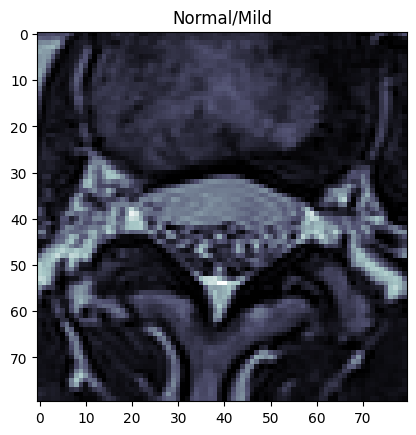

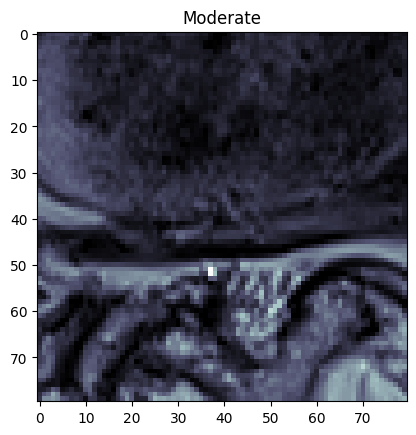

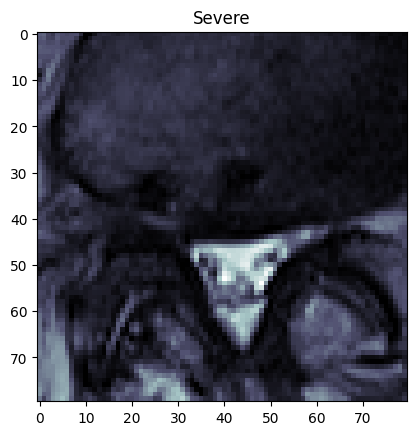

In [20]:
load_crop(train_df.iloc[0], plot=True, title='Normal/Mild', output=False)
load_crop(train_df.iloc[350], plot=True, title='Moderate', output=False)
load_crop(train_df.iloc[185], plot=True, title='Severe', output=False)

### L2/L3 crops

In [21]:
train_df[train_df.level_code == 2].groupby('severity').head(n=1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,level_code,severity_code
1,4003253,Left Subarticular Stenosis,L2/L3,Normal/Mild,2448190387,11,180.979730,158.764479,Axial T2,/home/jupyter/data/train_images/4003253/244819...,2,0
71,41477684,Left Subarticular Stenosis,L2/L3,Moderate,3749739759,9,278.863338,237.341108,Axial T2,/home/jupyter/data/train_images/41477684/37497...,2,1
134,75336136,Left Subarticular Stenosis,L2/L3,Severe,3843947211,14,179.823391,184.615385,Axial T2,/home/jupyter/data/train_images/75336136/38439...,2,2


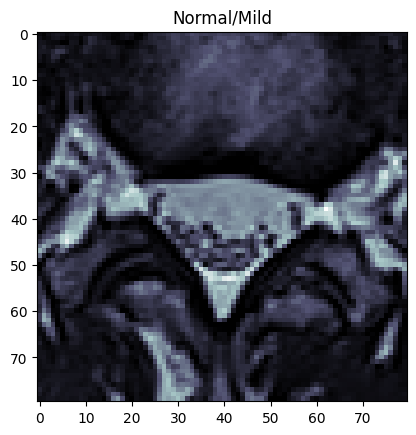

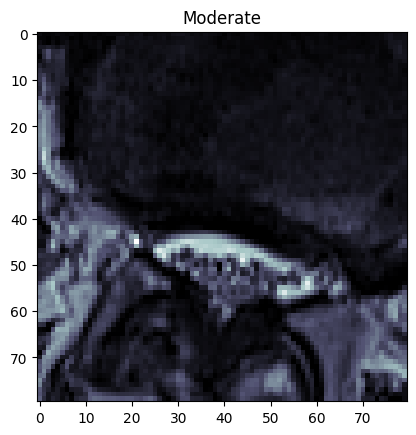

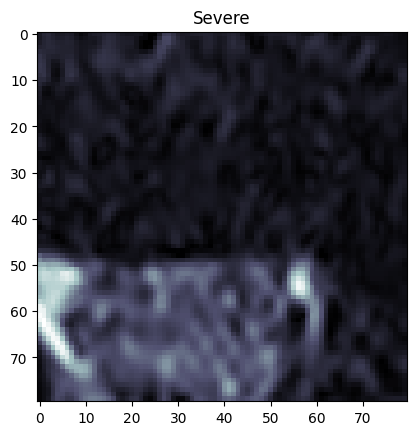

In [22]:
load_crop(train_df.iloc[1], plot=True, title='Normal/Mild', output=False)
load_crop(train_df.iloc[51], plot=True, title='Moderate', output=False)
load_crop(train_df.iloc[86], plot=True, title='Severe', output=False)

### L5/S1 crops

In [23]:
train_df[train_df.level_code == 5].groupby('severity').head(n=1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,level_code,severity_code
4,4003253,Left Subarticular Stenosis,L5/S1,Normal/Mild,2448190387,35,179.744208,161.853282,Axial T2,/home/jupyter/data/train_images/4003253/244819...,5,0
34,11943292,Left Subarticular Stenosis,L5/S1,Moderate,3800798510,16,174.915254,152.542373,Axial T2,/home/jupyter/data/train_images/11943292/38007...,5,1
132,73783367,Left Subarticular Stenosis,L5/S1,Severe,1885677897,35,253.100793,235.125708,Axial T2,/home/jupyter/data/train_images/73783367/18856...,5,2


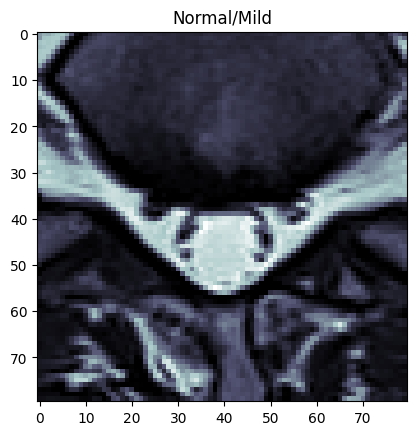

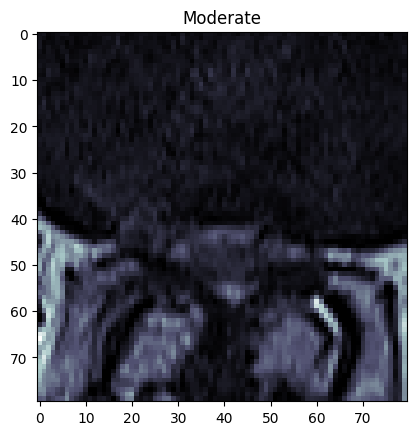

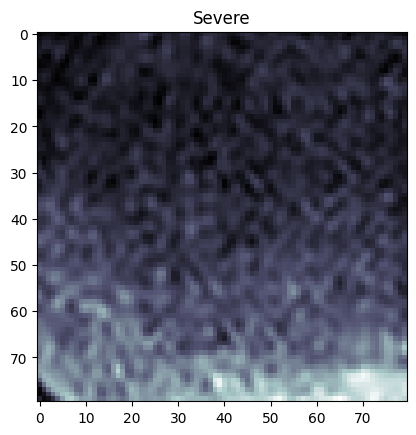

In [24]:
load_crop(train_df.iloc[4], plot=True, title='Normal/Mild', output=False)
load_crop(train_df.iloc[496], plot=True, title='Moderate', output=False)
load_crop(train_df.iloc[1955], plot=True, title='Severe', output=False)